In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns

# A. Reply Network

In [18]:
bsky_df = pd.read_csv("../data/bsky_reply_stats.csv")
ts_df = pd.read_csv("../data/ts_reply_stats.csv")

ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [19]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
ts_df = ts_df[columns_to_keep].reset_index(drop=True)

df = pd.concat([bsky_df, ts_df], ignore_index=True)
df = df.dropna(subset=["topic_label"])

metrics = ["max_depth", "size", "breadth", "structural_virality"]


In [20]:
# Merge similar topics
df["topic_label"] = df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [21]:
# Drop specified topic
df = df[df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_820705/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


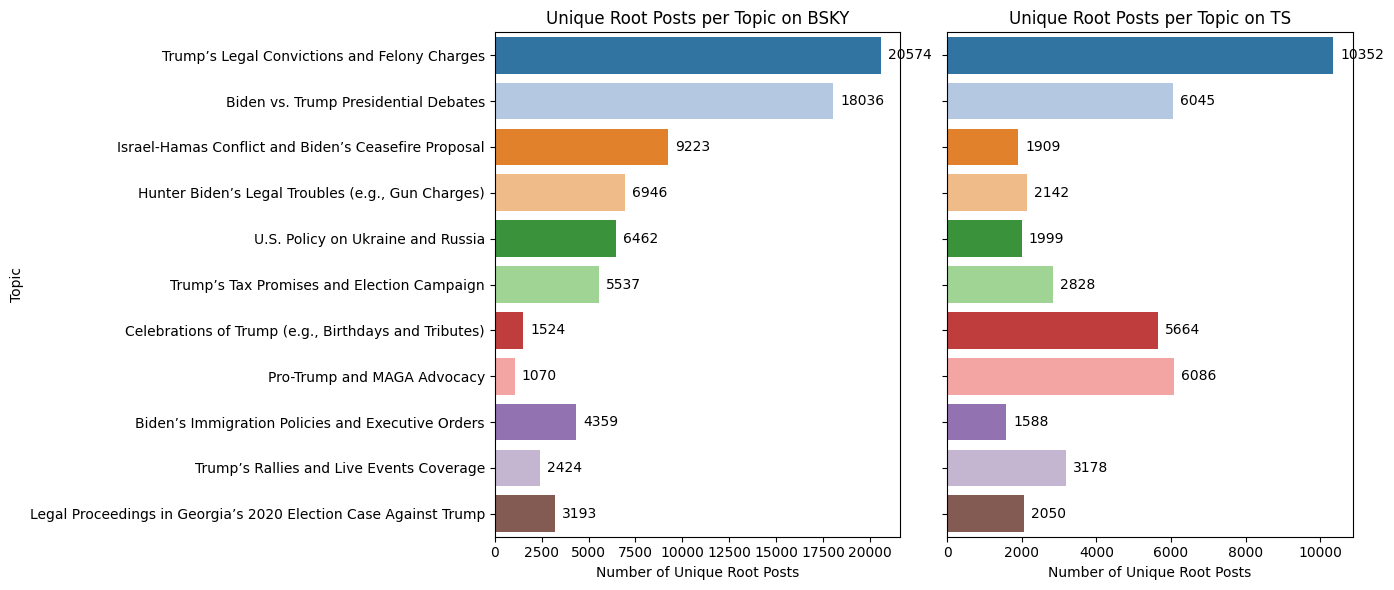

In [22]:
# Ensure consistent order of topics across both platforms
topic_order = (
    df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

### Observation
- The number of root posts under different topics on 2 platforms are different.
- Presidential debates and Trump legal convictions are two topics that have the most root posts on both platforms.
- For the rest of topics, it is clear that Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.


## 2. general cross-platform comparison

In [23]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


In [24]:
# Function to compute CCDF
def empirical_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

In [56]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(
    np.linspace(0, 1, len(sorted(df["topic_label"].unique())))
)  # Use tab20 colormap
sorted_topics = sorted(df["topic_label"].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}


def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data["topic_label"] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(
            sorted_vals,
            ccdf_vals,
            label=f"{topic}",
            linewidth=2,
            color=topic_color_map[topic],
        )
    ax.set_xscale("log")  # Apply log scale to x-axis
    ax.set_yscale("log")
    ax.set_xlabel(metric)
    ax.set_ylabel("CCDF (%)")
    ax.set_title(f"CCDF of {metric} by Topic")
    ax.grid()


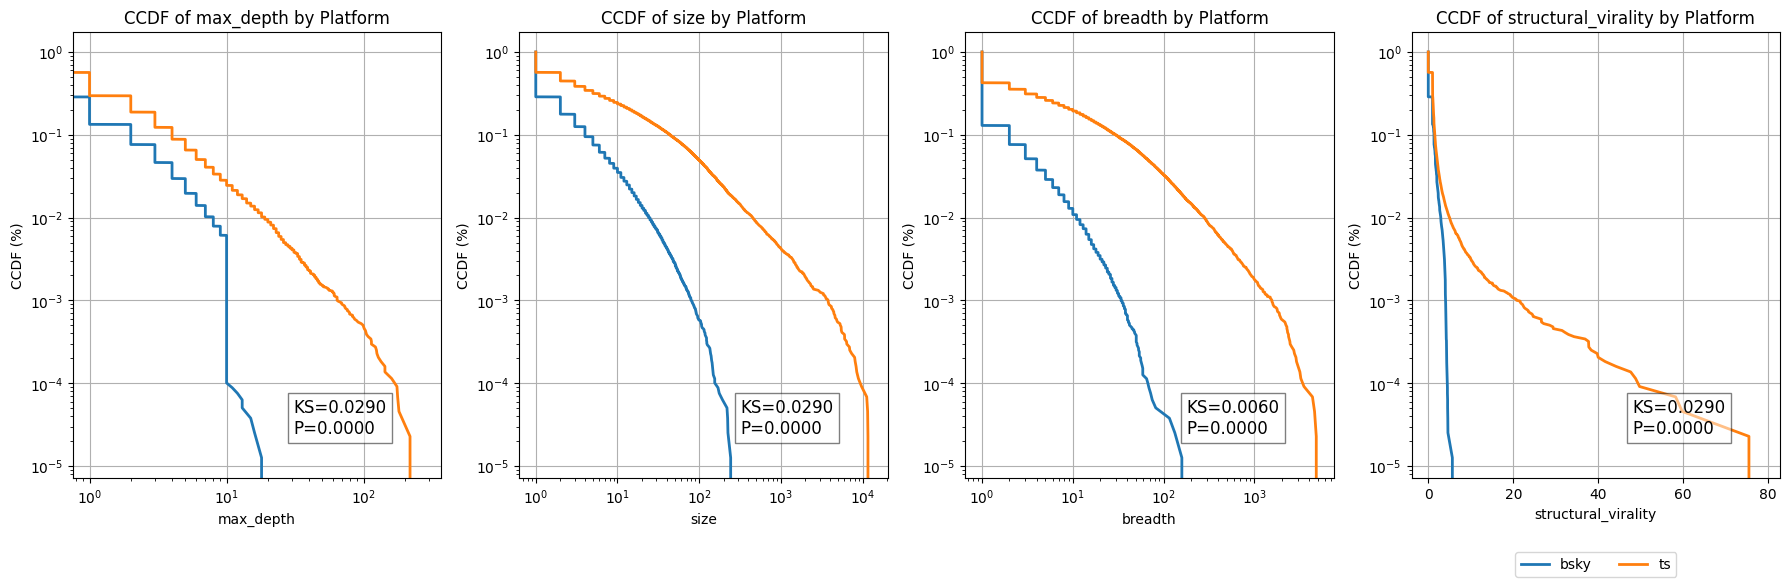

In [54]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

In [27]:
df_std.max_depth.max()

NameError: name 'df_std' is not defined

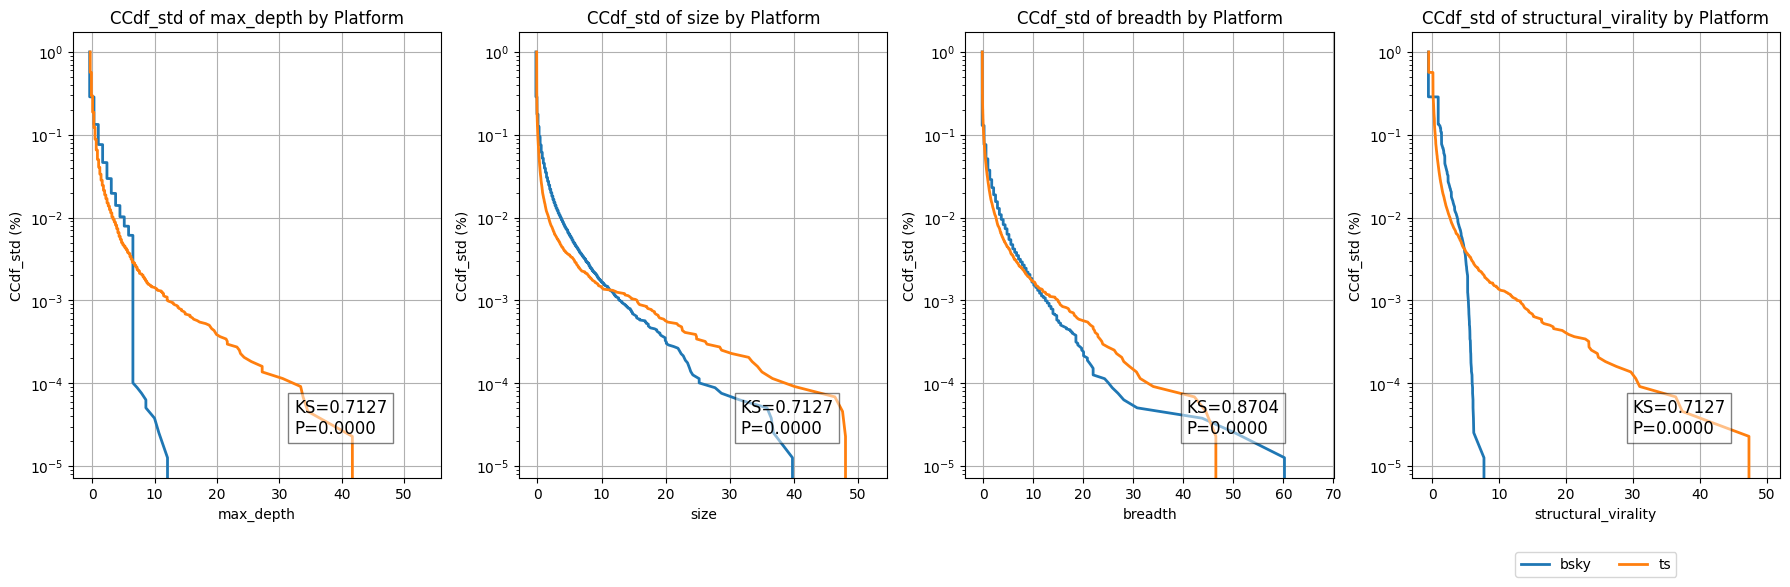

In [28]:
# Standardize the data
df_std = df.copy()
mask_bsky = df_std["platform"] == "bsky"
df_std.loc[mask_bsky, metrics] = (
    df_std.loc[mask_bsky, metrics] - df_std.loc[mask_bsky, metrics].mean()
) / df_std.loc[mask_bsky, metrics].std()

# Standardize the metrics for platform "ts"
mask_ts = df_std["platform"] == "ts"
df_std.loc[mask_ts, metrics] = (
    df_std.loc[mask_ts, metrics] - df_std.loc[mask_ts, metrics].mean()
) / df_std.loc[mask_ts, metrics].std()

# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df_std[df_std["platform"] == "bsky"][metric].dropna()
    ts_vals = df_std[df_std["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df_std = pd.DataFrame(ks_results)
# Plot CCdf_std comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df_std[df_std["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf_std = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf_std, label=f"{platform}", linewidth=2)

    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCdf_std (%)")
    axes[idx].set_title(f"CCdf_std of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df_std.loc[
        ks_overall_df_std["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

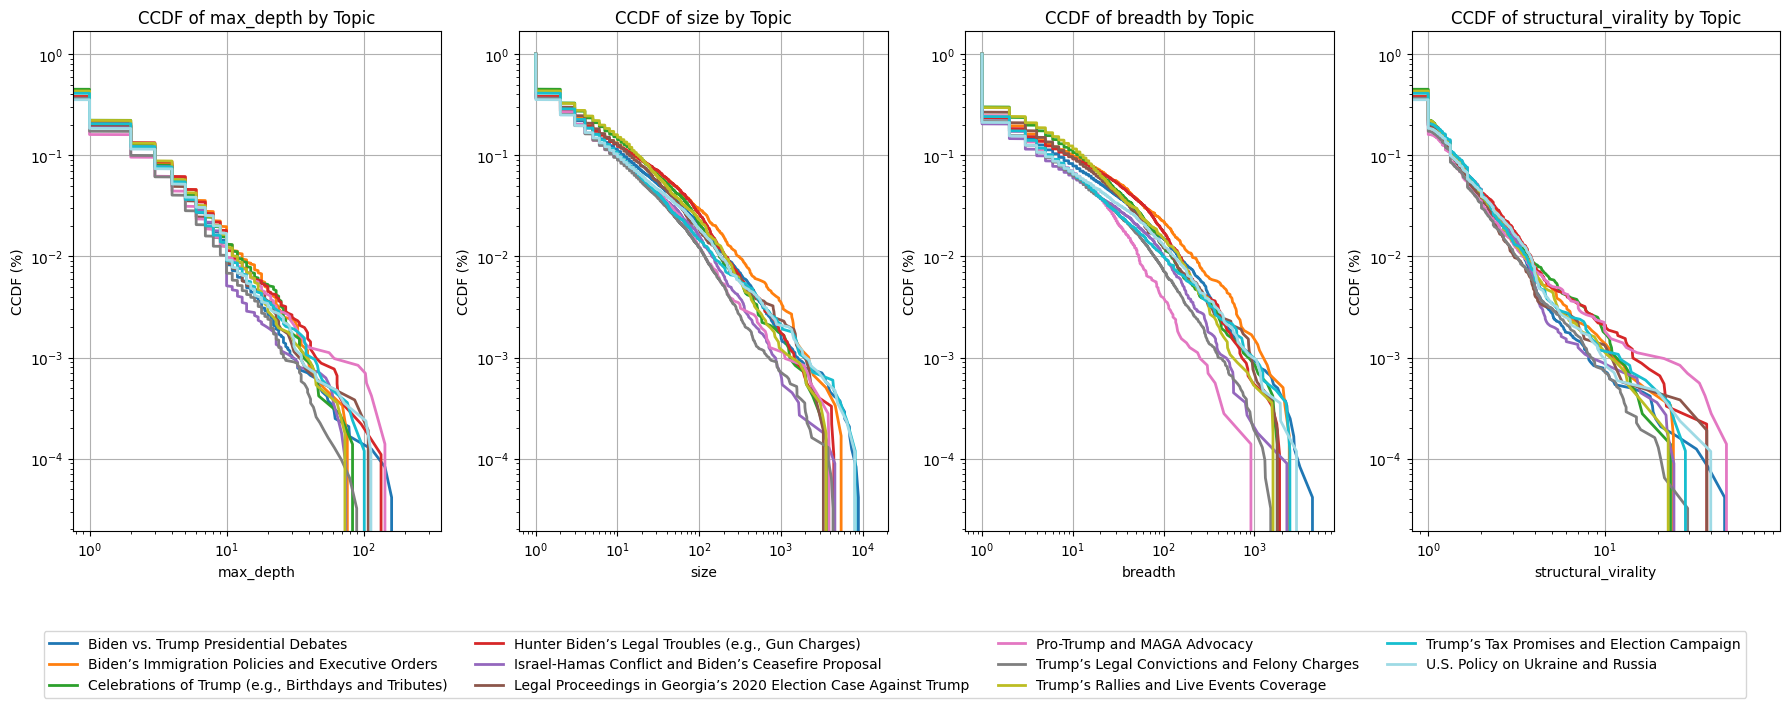

In [29]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

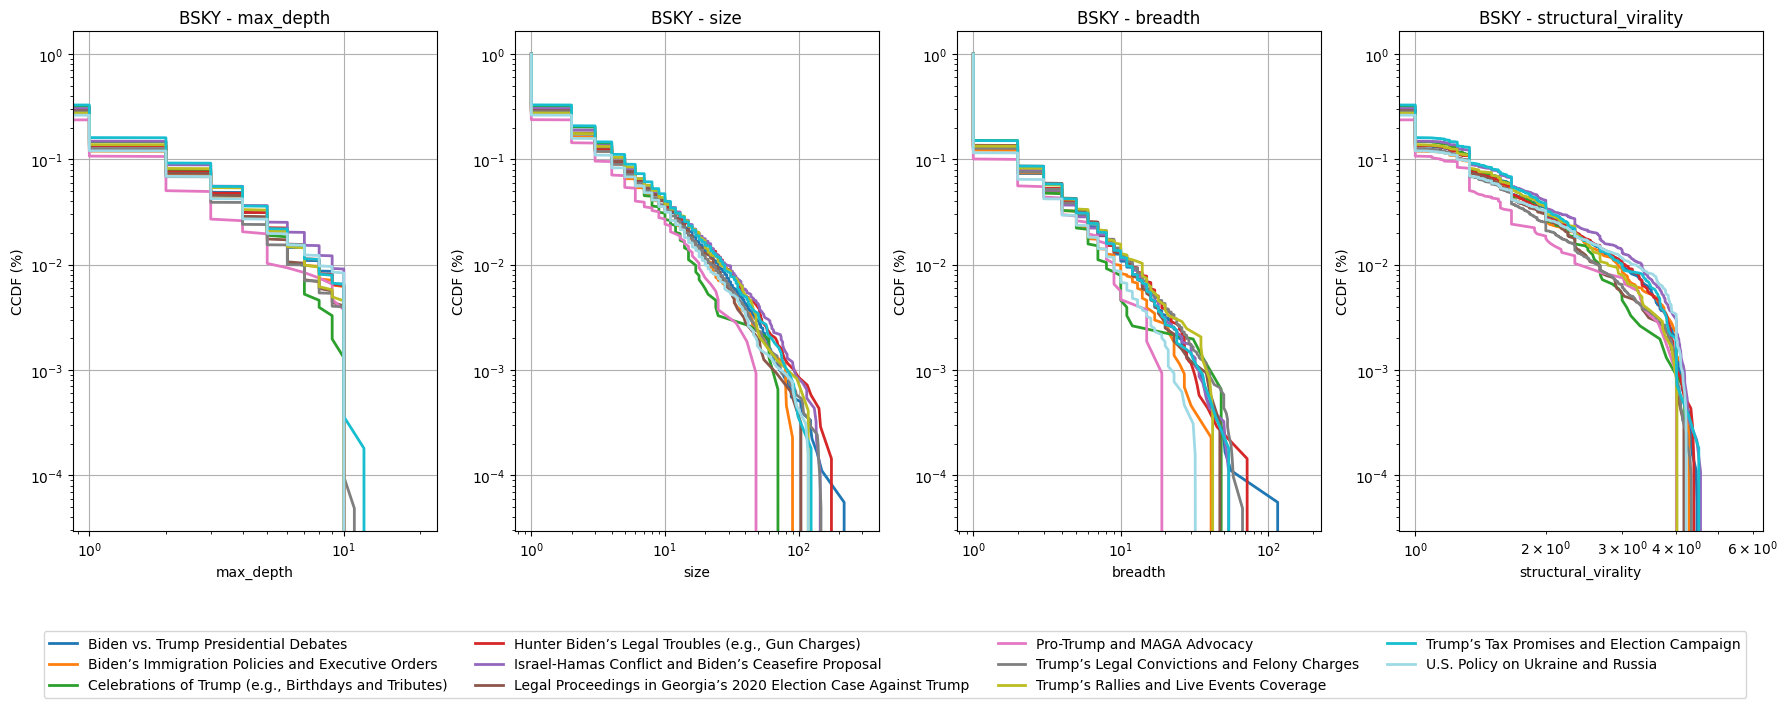

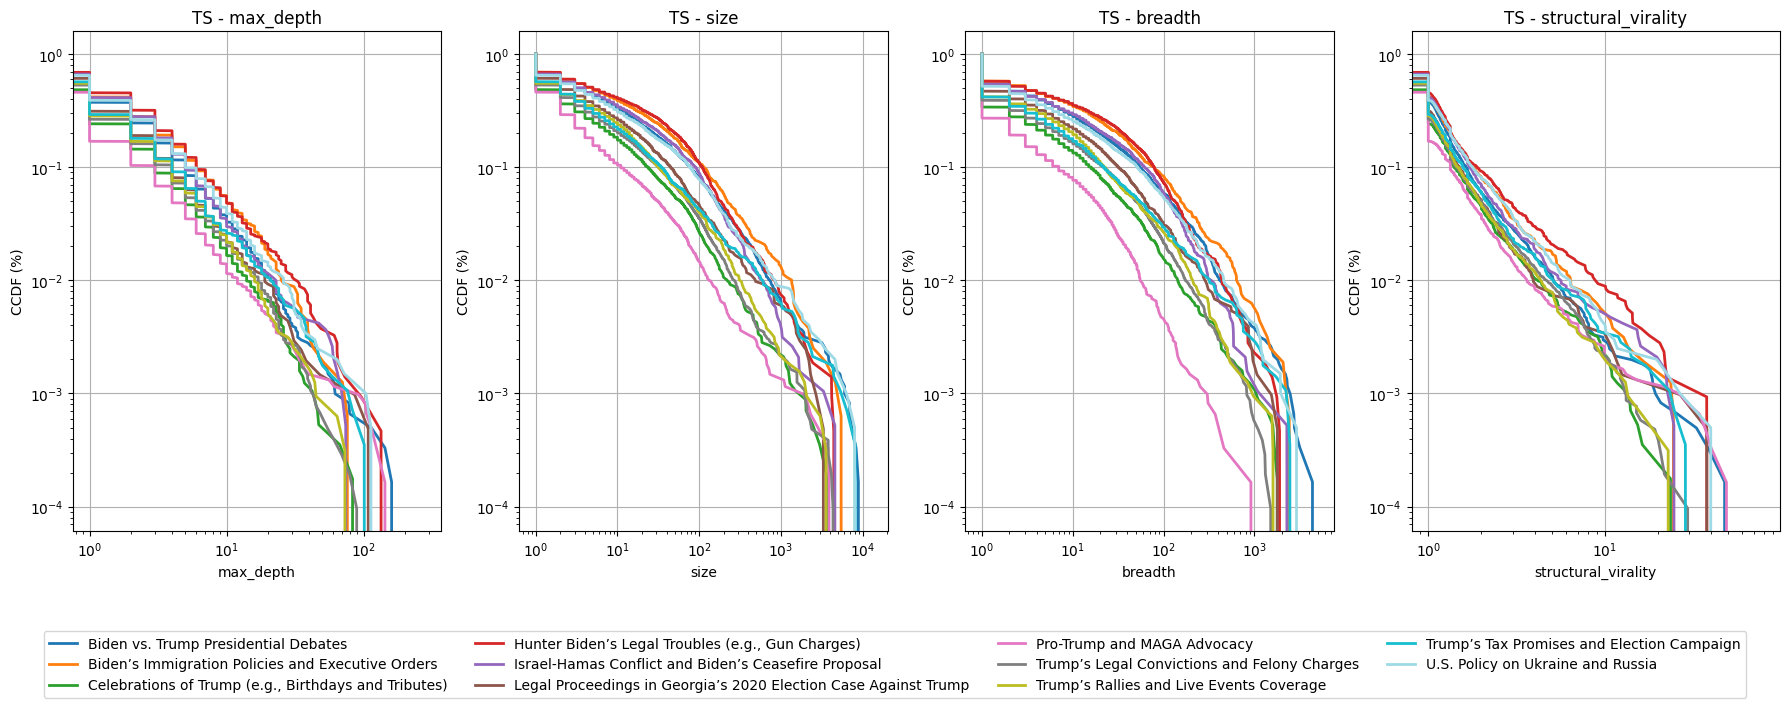

In [58]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = df[df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()


## 5. Quantify the difference

# B. Reposts Network

In [31]:
rp_bsky_df = pd.read_csv("../data/bsky_repost_stats.csv")
rp_ts_df = pd.read_csv("../data/ts_repost_stats.csv")

rp_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [32]:
rp_bsky_df.reset_index(inplace=True)

In [33]:
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)
rp_ts_df = rp_ts_df[columns_to_keep].reset_index(drop=True)

rp_df = pd.concat([rp_bsky_df, rp_ts_df], ignore_index=True)

rp_df = rp_df.dropna(subset=["topic_label"])


In [34]:
rp_df["topic_label"] = rp_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

rp_df = rp_df[
    rp_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of reposts under different topics on 2 platforms

/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


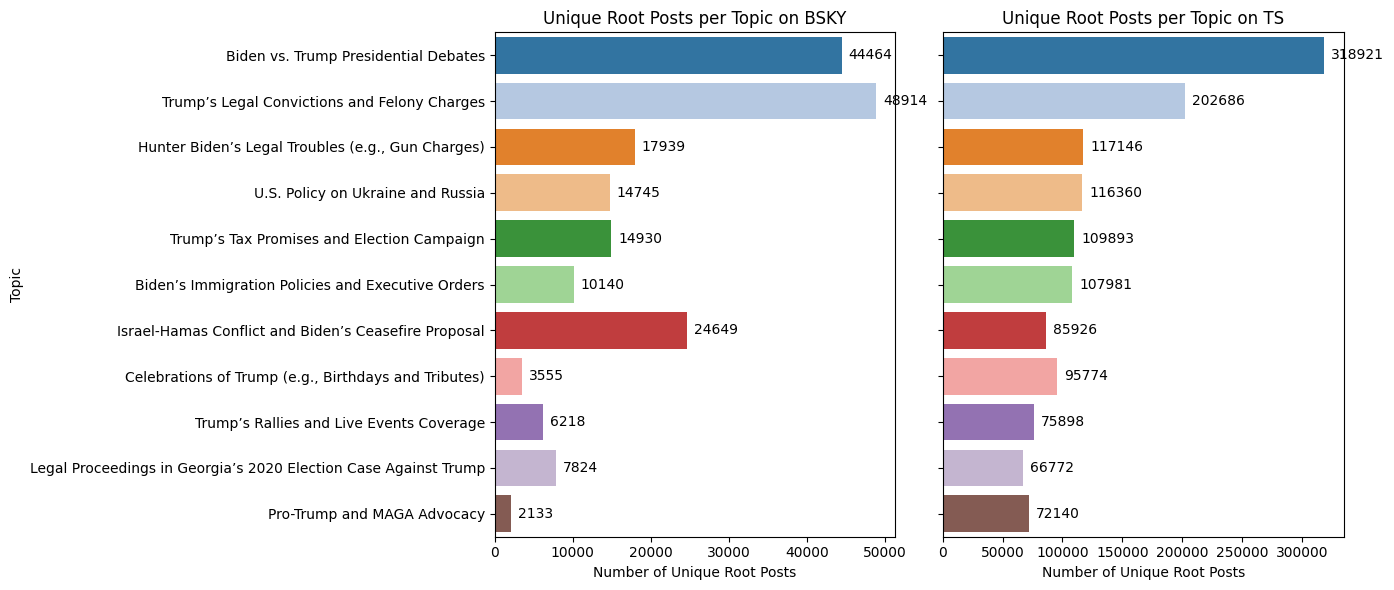

In [35]:
topic_order = (
    rp_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = rp_df[rp_df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()


## 2. General cross-platform comparison

In [36]:
rp_metrics = ["max_depth", "size", "breadth", "structural_virality"]

ks_results = []
for metric in rp_metrics:
    bsky_vals = rp_df[rp_df["platform"] == "bsky"][metric].dropna()
    ts_vals = rp_df[rp_df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


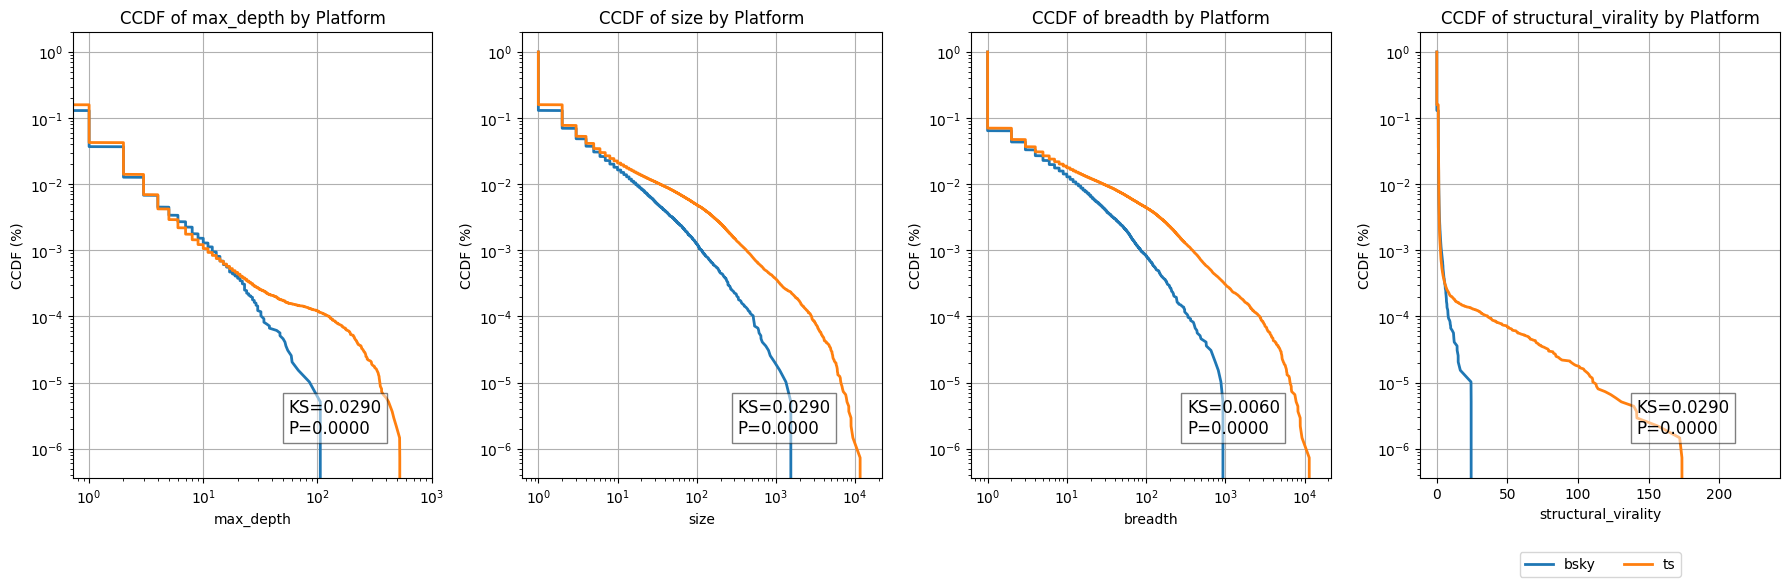

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(rp_metrics):
    for platform in ["bsky", "ts"]:
        values = rp_df[rp_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()


## 3. General cross-topic comparison

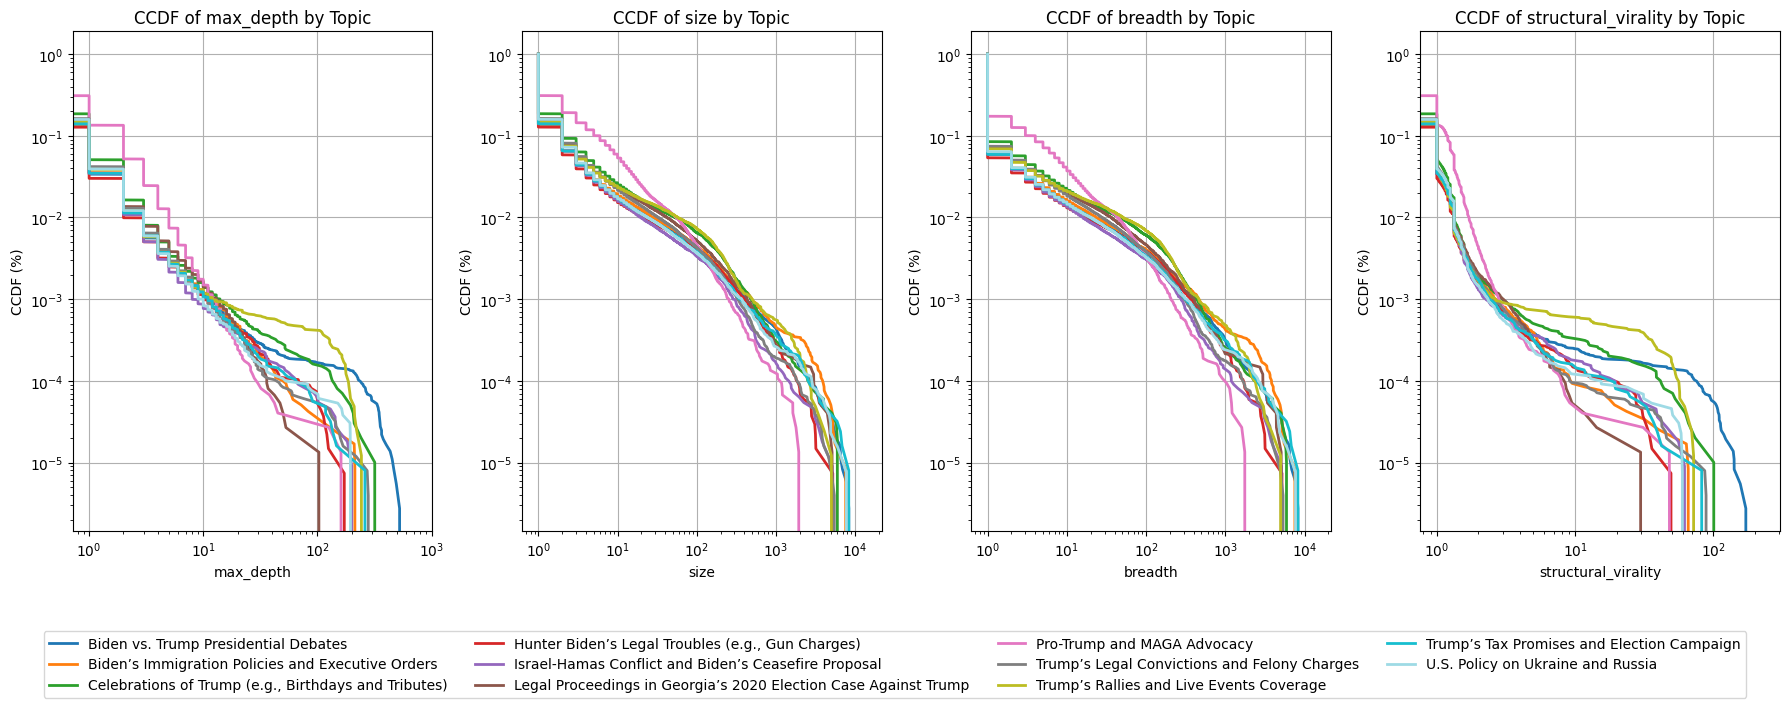

In [40]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(rp_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. Comparison by platform & by topic

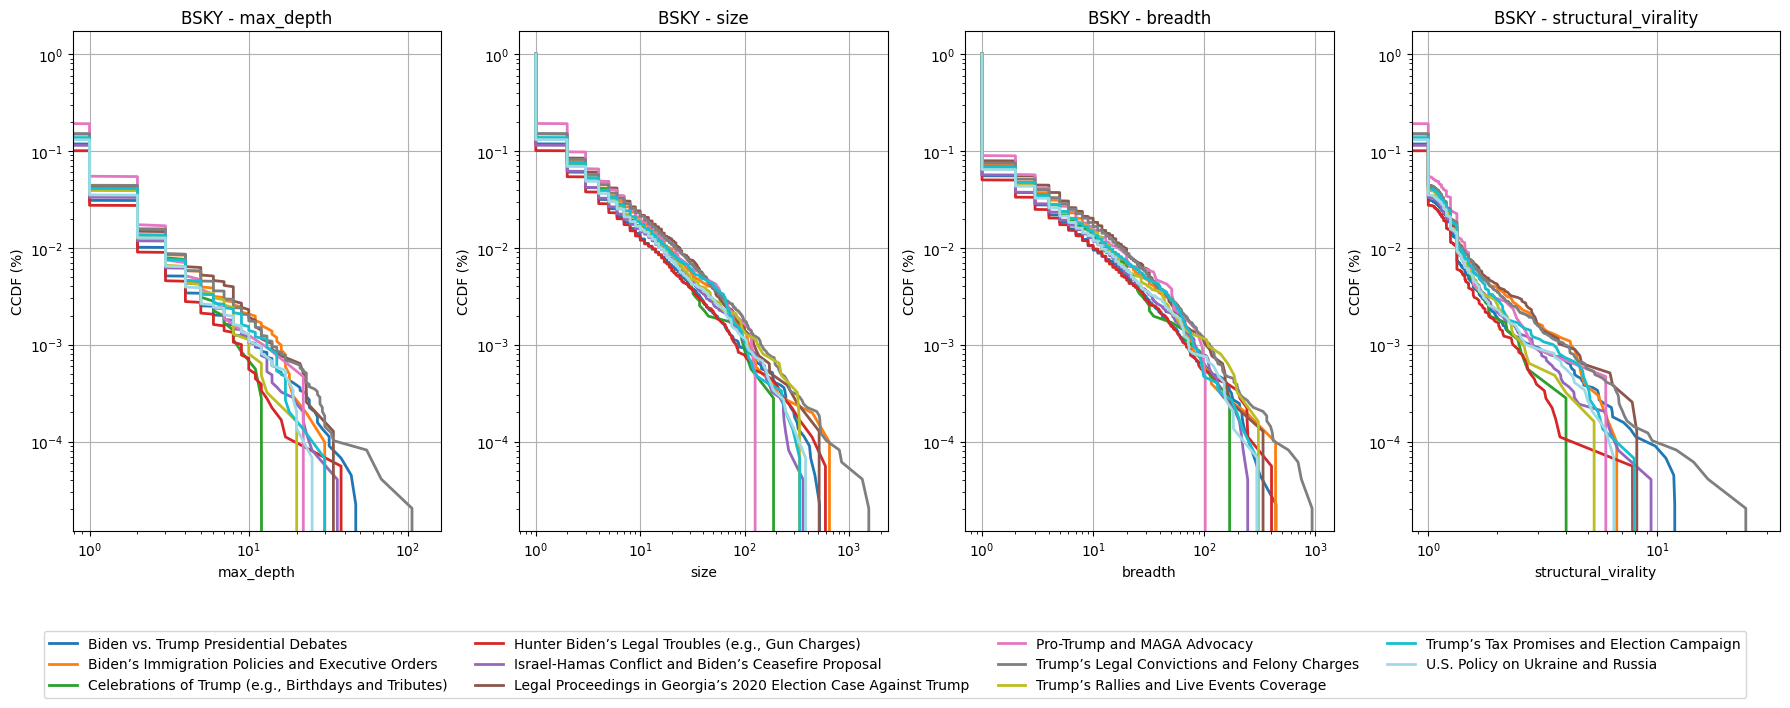

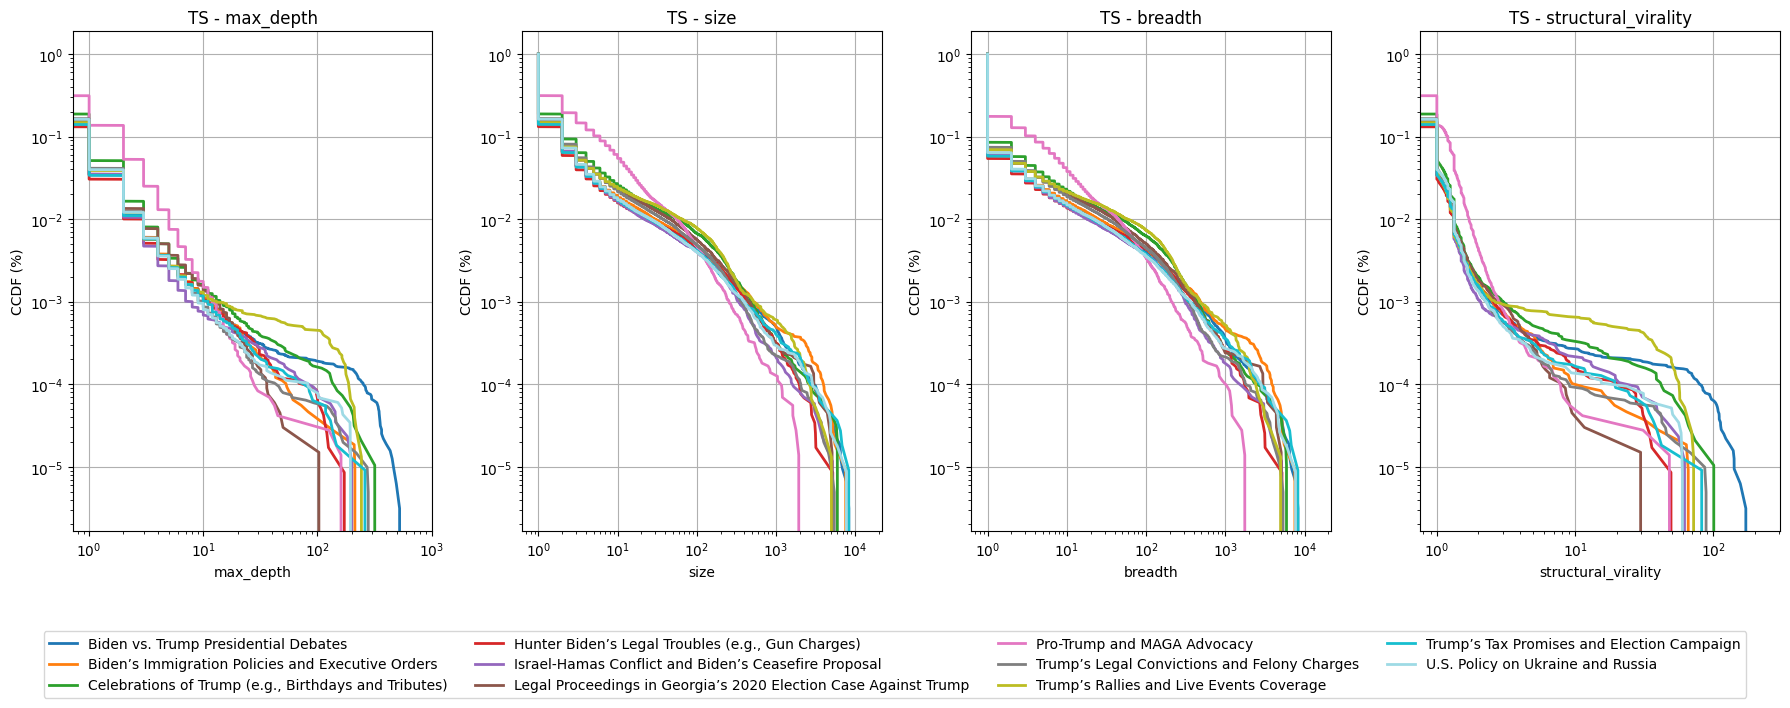

In [57]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = rp_df[rp_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# C. Combined Network

In [44]:
c_bsky_df = pd.read_csv("../data/bsky_combined_stats.csv")
c_ts_df = pd.read_csv("../data/ts_combined_stats.csv")

c_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [45]:
c_bsky_df = c_bsky_df[columns_to_keep].reset_index(drop=True)
c_ts_df = c_ts_df[columns_to_keep].reset_index(drop=True)

c_df = pd.concat([c_bsky_df, c_ts_df], ignore_index=True)
c_df = c_df.dropna(subset=["topic_label"])

In [46]:
# Merge similar topics
c_df["topic_label"] = c_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [47]:
# Drop specified topic
c_df = c_df[
    c_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


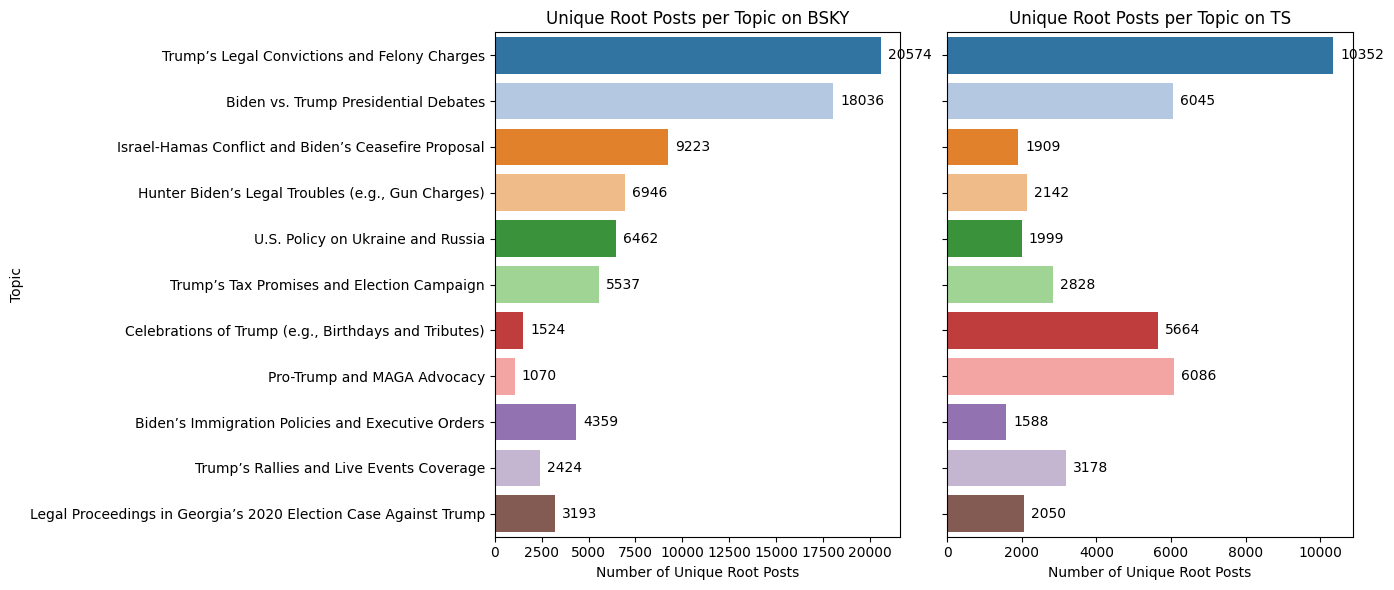

In [48]:
# Ensure consistent order of topics across both platforms
topic_order = (
    c_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

## 2. general cross-platform comparison

In [49]:
# Compute KS statistics for each metric
c_ks_results = []
for metric in metrics:
    c_bsky_vals = c_df[c_df["platform"] == "bsky"][metric].dropna()
    c_ts_vals = c_df[c_df["platform"] == "ts"][metric].dropna()
    c_ks_stat, c_p_value = ks_2samp(c_bsky_vals, c_ts_vals)
    c_ks_results.append(
        {"Metric": metric, "KS Statistic": c_ks_stat, "P-value": c_p_value}
    )

c_ks_overall_df = pd.DataFrame(c_ks_results)

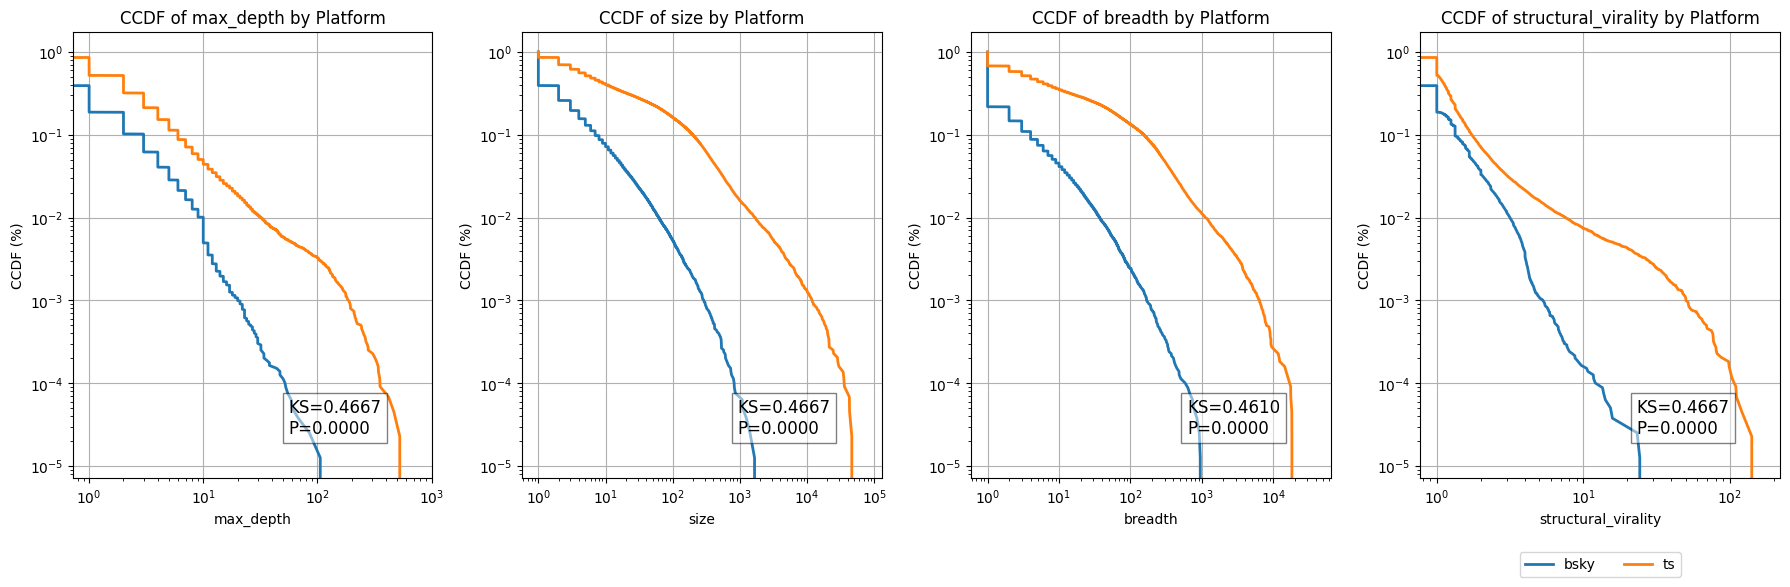

In [50]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = c_df[c_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    c_ks_stat, p_value = c_ks_overall_df.loc[
        c_ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={c_ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

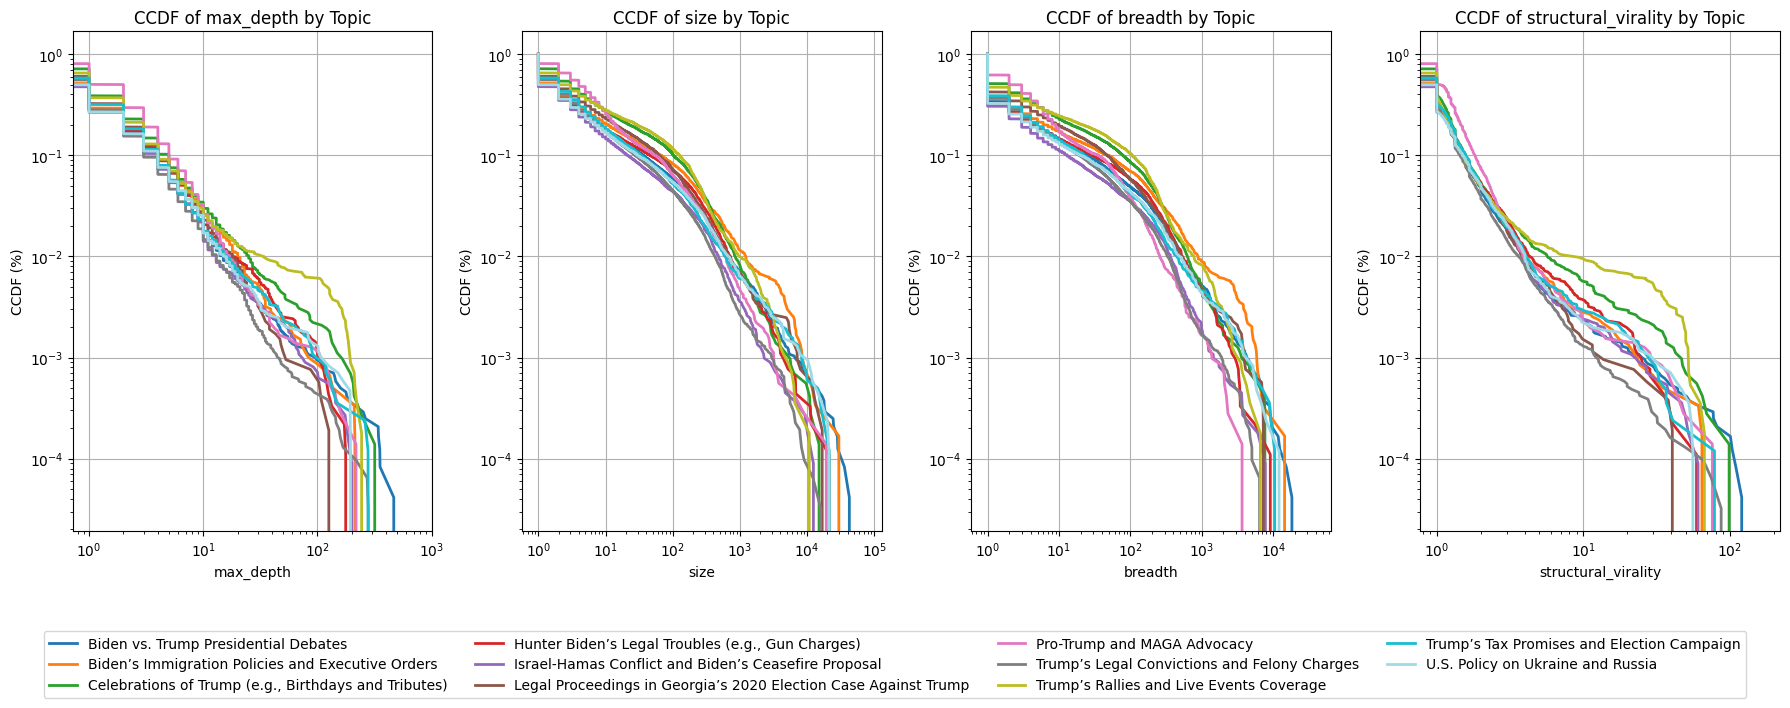

In [51]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(c_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

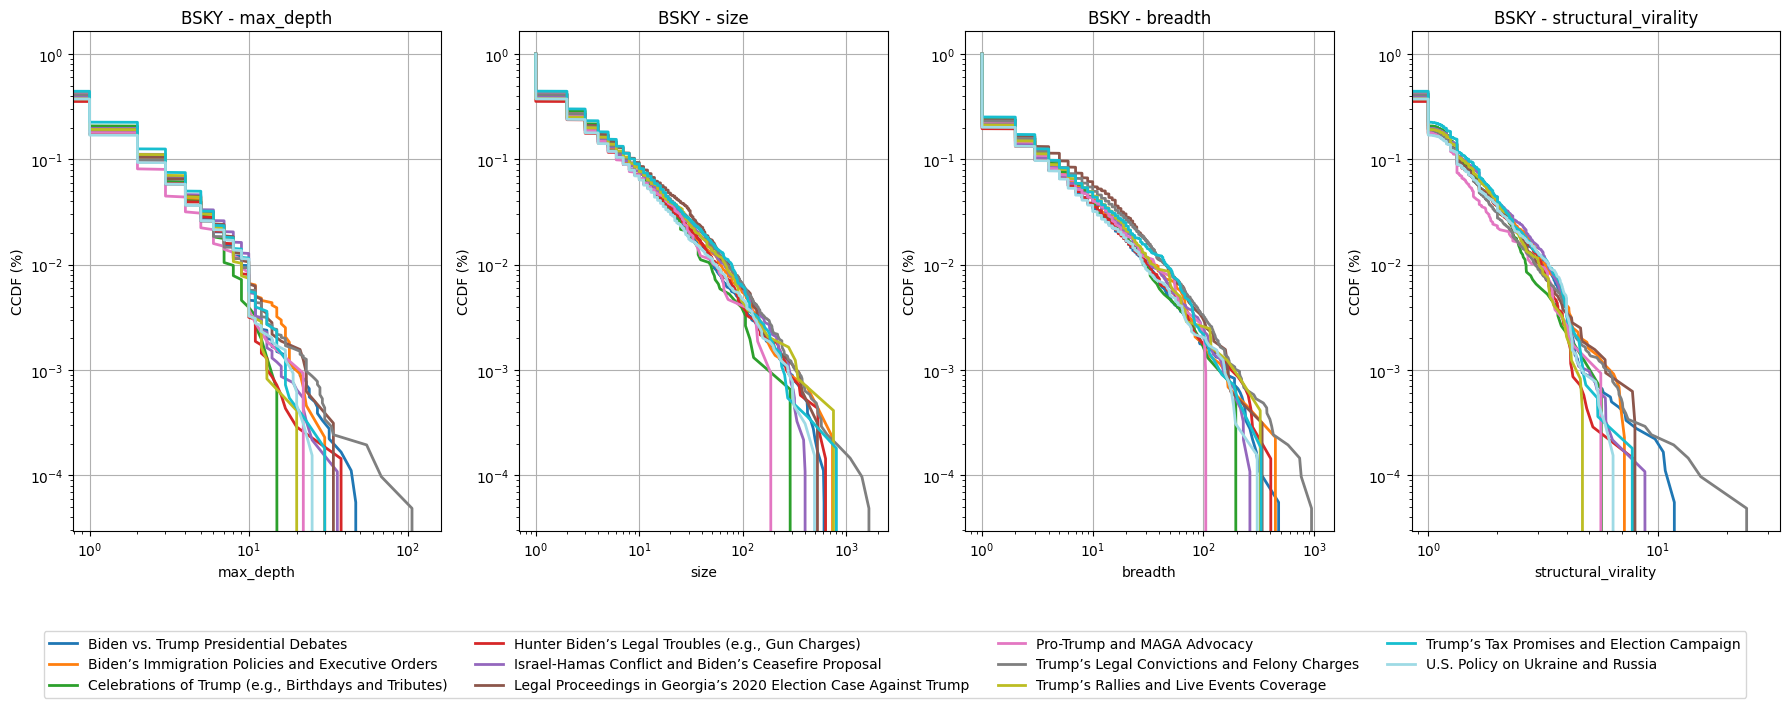

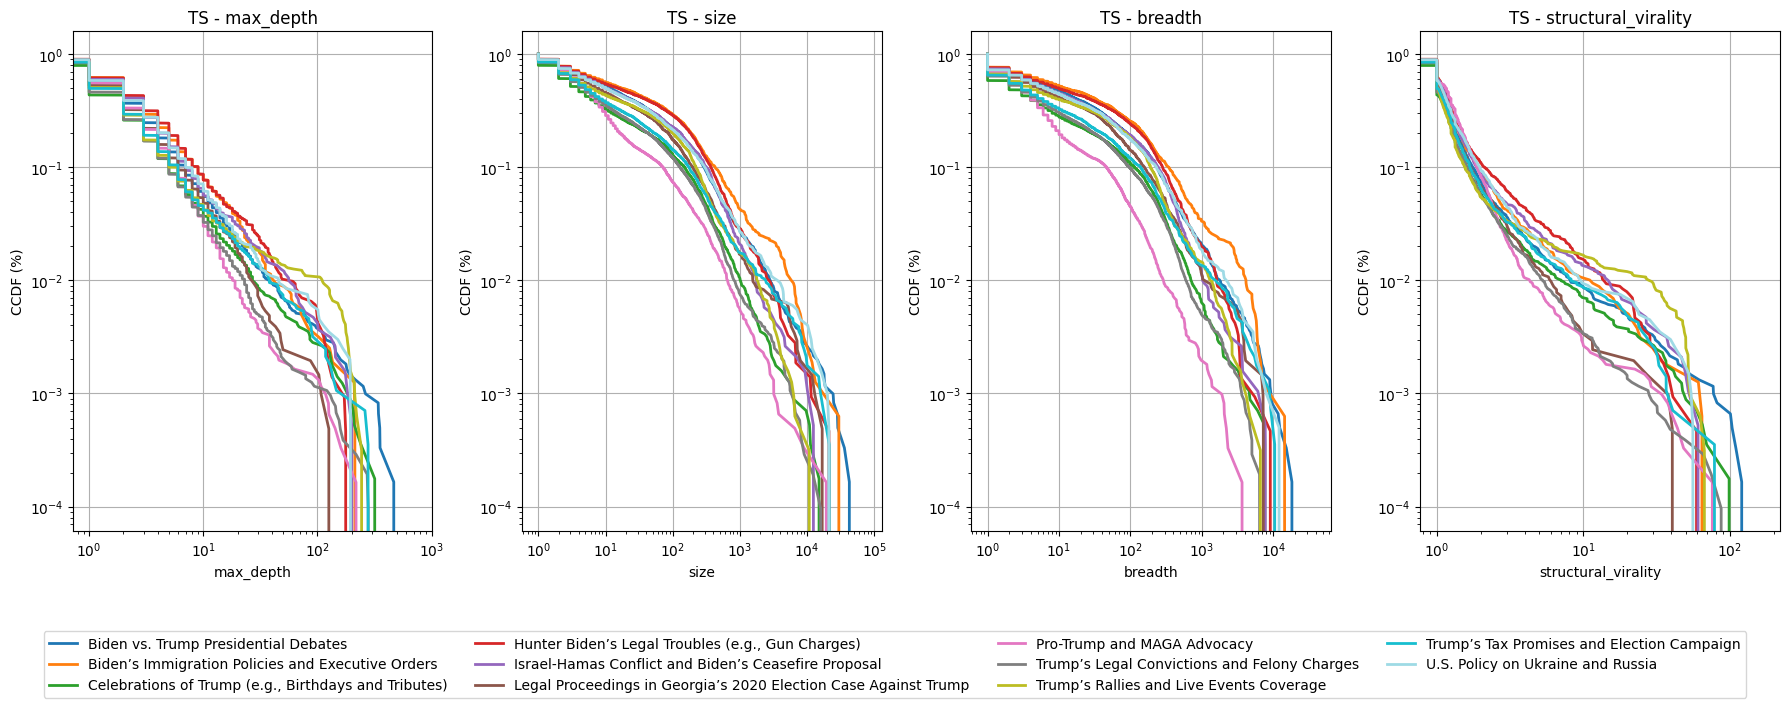

In [52]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = c_df[c_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# Summary

1. Topic-wise comparison: Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.
2. Topic-wise ccdf: 
    1. Reply network: most salient distribution for BlueSky is from presidential debates and same for Truth Social.
    2. Repost network: most salient distribution for BlueSky is from Trump's legal convictions and For Truth Social, it is from presidential debates.
    3. Combined network: as same as repost network, but the Truth Social phenomenon is more pronounced.
3. 